In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [6]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [7]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [56]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

Train Error	Test Error	Adv Error
0.003333	0.012400	0.742400
0.003033	0.012400	0.762100
0.002050	0.011100	0.742200
0.002100	0.011900	0.723900
0.001733	0.011600	0.744800
0.000400	0.011100	0.733000
0.000133	0.011100	0.729600
0.000050	0.011000	0.720100
0.000033	0.010900	0.716300
0.000017	0.010900	0.713300


In [9]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

Train Error	Test Error	Adv Error


0.025567	0.012200	0.029600
0.022683	0.010500	0.028200
0.020217	0.009900	0.028700
0.017833	0.008800	0.027400
0.015717	0.008900	0.027800


In [11]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, 
                                             num_iter=40, randomize=True)[0])

FGSM:  0.0256
PGD, 40 iter:  0.0278
PGD, small_alpha:  0.0276
PGD, randomized:  0.0277


In [12]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [24]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    # 使用 add_subplot 创建 3D 坐标轴
    ax = fig.add_subplot(111, projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

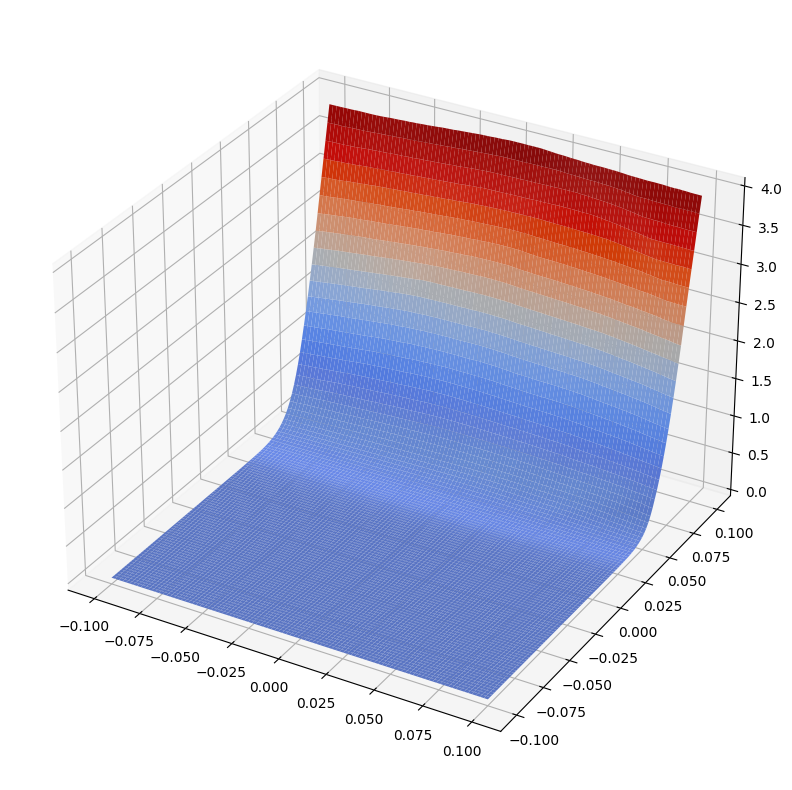

In [25]:
draw_loss(model_cnn, X[0:1], 0.1)

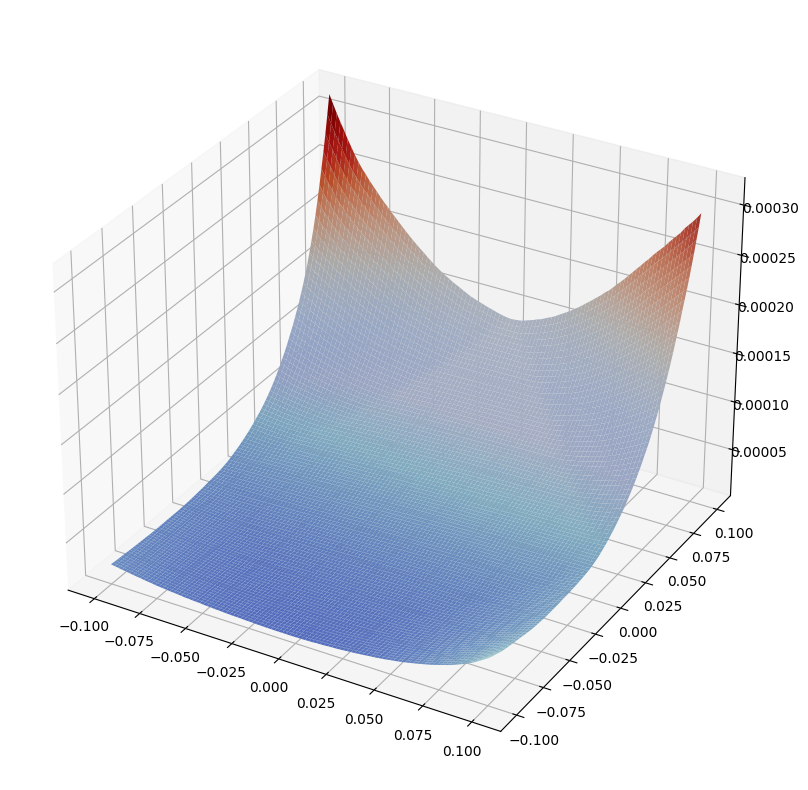

In [26]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

In [ ]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()    


def epoch_robust_bound(loader, model, epsilon):
    total_err = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

In [40]:
epoch_robust_bound(test_loader, model_cnn_robust, 0.1)

1.0

In [41]:
epoch_robust_bound(test_loader, model_cnn_robust, 0.0001)

0.02

In [42]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]  
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [51]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [52]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)

    # 调参使用
    if t == 4:
       for param_group in opt.param_groups:
           param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err
0.000000	0.835771	0.031500	1.000000
0.000100	0.125941	0.021500	1.000000
0.001000	0.120870	0.022600	1.000000
0.010000	0.341352	0.028100	1.000000
0.010000	0.160670	0.025400	1.000000
0.050000	0.560360	0.030000	0.975400
0.050000	0.427368	0.030300	0.963600
0.050000	0.384079	0.030600	0.930500
0.050000	0.357235	0.030200	0.886300
0.050000	0.337236	0.030800	0.830700
0.100000	0.838830	0.041600	0.185400
0.100000	0.637333	0.043000	0.164000
0.100000	0.562028	0.042400	0.147400
0.100000	0.515194	0.040700	0.135600
0.100000	0.475985	0.041400	0.127500
0.100000	0.441126	0.040900	0.120200
0.100000	0.412448	0.040300	0.112500
0.100000	0.389139	0.040600	0.108200
0.100000	0.368990	0.038800	0.103100
0.100000	0.352168	0.039200	0.101400
0.100000	0.338744	0.038700	0.097300
0.100000	0.326916	0.038000	0.094100
0.100000	0.316879	0.037100	0.092000
0.100000	0.308328	0.037400	0.088800
0.100000	0.300363	0.037500	0.089300


In [53]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0689
